# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

FileNotFoundError: [Errno 2] No such file or directory: 'behavior_data/shorter_armflapping'

In [ ]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

In [ ]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

In [ ]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 

X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [11]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [5]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [7]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [8]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [ ]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [9]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [23]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [12]:
import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y
X, y = shuffle(X, y, seed = 68)

In [ ]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [3]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6616 - accuracy: 0.5625 - precision_39: 0.5246 - recall_39: 0.8421 - val_loss: 1.0047 - val_accuracy: 0.4000 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 360ms/step - loss: 0.7095 - accuracy: 0.5875 - precision_39: 1.0000 - recall_39: 0.1316 - val_loss: 0.6628 - val_accuracy: 0.6500 - val_precision_39: 1.0000 - val_recall_39: 0.4167
Epoch 3/75
3/3 [==============================] - 1s 358ms/step - loss: 0.6601 - accuracy: 0.6500 - precision_39: 0.6667 - recall_39: 0.5263 - val_loss: 0.6193 - val_accuracy: 0.7000 - val_precision_39: 0.6875 - val_recall_39: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 420ms/step - loss: 0.6520 - accuracy: 0.6500 - precision_39: 0.6087 - recall_39: 0.7368 - val_loss: 0.5938 - val_accuracy: 0.7500 - val_precision_39: 0.7333 - val_recall_39: 0.9167
Epoch 5/75
3/3 [==============================] - 1s 366

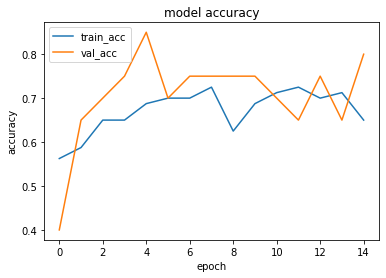

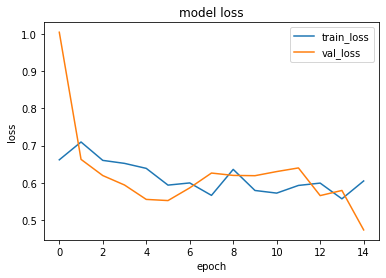

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.4717306]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.5770119]]


1it [00:00, 12520.31it/s]


prediction for video armflapping_2.mov is [[0.52807957]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.4365571]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.42726266]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.42556027]]
Epoch 1/75
3/3 [==============================] - 1s 326ms/step - loss: 0.7080 - accuracy: 0.4250 - precision_40: 0.4000 - recall_40: 0.3000 - val_loss: 0.6853 - val_accuracy: 0.4000 - val_precision_40: 0.4375 - val_recall_40: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 330ms/step - loss: 0.6362 - accuracy: 0.5750 - precision_40: 0.5469 - recall_40: 0.8750 - val_loss: 0.6731 - val_accuracy: 0.5500 - val_precision_40: 0.5294 - val_recall_40: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6182 - accuracy: 0.6625 - precision_40: 0.6327 - recall_40: 0.7750 - val_loss: 0.6547 - val_accuracy: 0.8000 - val_precision_40: 0.7500 - val_recall_40: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6022 - accuracy: 0.7250 - precision_40: 0.7500 - recall_40: 0.6750 - val_loss: 0.5867 - val_accuracy: 0.7000 - val_precision_40: 0.6667 - val_recall_40: 0.8000
Epoch 5/75


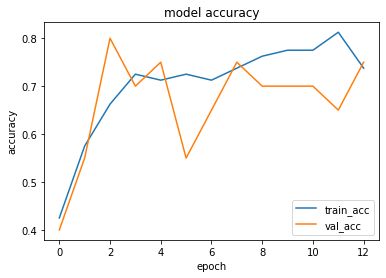

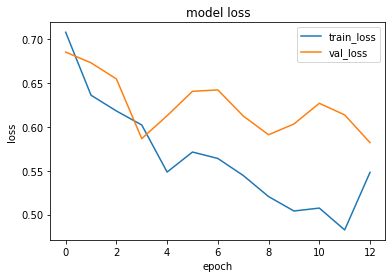

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.56150496]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.75020576]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.68002576]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.4223921]]


1it [00:00, 11748.75it/s]


prediction for video control_2.mov is [[0.4058085]]


1it [00:00, 12300.01it/s]


prediction for video control_3.mov is [[0.39068666]]
Epoch 1/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6851 - accuracy: 0.5250 - precision_41: 0.5294 - recall_41: 0.4500 - val_loss: 0.6542 - val_accuracy: 0.5500 - val_precision_41: 0.5263 - val_recall_41: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6487 - accuracy: 0.6625 - precision_41: 0.6000 - recall_41: 0.9750 - val_loss: 0.6425 - val_accuracy: 0.7500 - val_precision_41: 0.8571 - val_recall_41: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6100 - accuracy: 0.7625 - precision_41: 0.7692 - recall_41: 0.7500 - val_loss: 0.6083 - val_accuracy: 0.7000 - val_precision_41: 0.7500 - val_recall_41: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 432ms/step - loss: 0.5965 - accuracy: 0.6875 - precision_41: 0.6471 - recall_41: 0.8250 - val_loss: 0.6137 - val_accuracy: 0.6500 - val_precision_41: 0.6667 - val_recall_41: 0.6000
Epoch 5/75


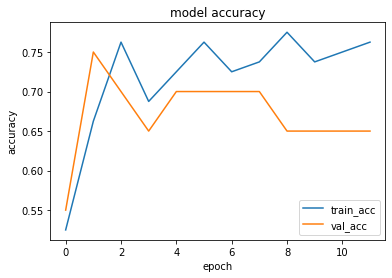

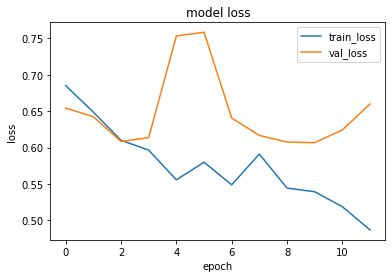

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.169754]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.7146752]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.25300848]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.15279639]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.14762044]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.14682776]]
Epoch 1/75
3/3 [==============================] - 1s 331ms/step - loss: 0.7468 - accuracy: 0.4750 - precision_42: 0.4902 - recall_42: 0.6098 - val_loss: 0.6925 - val_accuracy: 0.5000 - val_precision_42: 0.4737 - val_recall_42: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6726 - accuracy: 0.6375 - precision_42: 0.6200 - recall_42: 0.7561 - val_loss: 0.6673 - val_accuracy: 0.6000 - val_precision_42: 0.6000 - val_recall_42: 0.3333
Epoch 3/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6412 - accuracy: 0.6750 - precision_42: 0.7778 - recall_42: 0.5122 - val_loss: 0.6643 - val_accuracy: 0.6500 - val_precision_42: 0.6000 - val_recall_42: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6081 - accuracy: 0.7250 - precision_42: 0.7021 - recall_42: 0.8049 - val_loss: 0.6652 - val_accuracy: 0.7000 - val_precision_42: 0.6154 - val_recall_42: 0.8889
Epoch 5/75


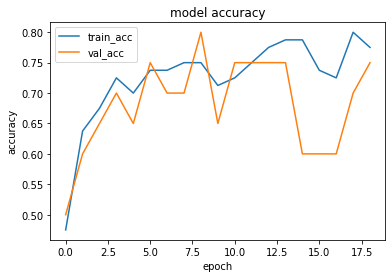

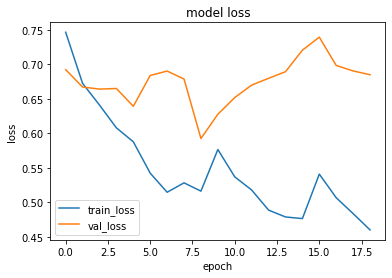

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.45067838]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.46956545]]


1it [00:00, 18641.35it/s]


prediction for video armflapping_2.mov is [[0.759902]]


1it [00:00, 16578.28it/s]


prediction for video control_1.mov is [[0.3130223]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.28920335]]


1it [00:00, 13025.79it/s]


prediction for video control_3.mov is [[0.28082007]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6968 - accuracy: 0.4125 - precision_43: 0.4444 - recall_43: 0.5854 - val_loss: 0.6461 - val_accuracy: 0.7000 - val_precision_43: 0.6364 - val_recall_43: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6629 - accuracy: 0.6750 - precision_43: 0.6744 - recall_43: 0.7073 - val_loss: 0.5929 - val_accuracy: 0.7500 - val_precision_43: 0.7000 - val_recall_43: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 364ms/step - loss: 0.6083 - accuracy: 0.7000 - precision_43: 0.6604 - recall_43: 0.8537 - val_loss: 0.6194 - val_accuracy: 0.7500 - val_precision_43: 0.7000 - val_recall_43: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6939 - accuracy: 0.6500 - precision_43: 0.6970 - recall_43: 0.5610 - val_loss: 0.5795 - val_accuracy: 0.7500 - val_precision_43: 0.7500 - val_recall_43: 0.6667
Epoch 5/75


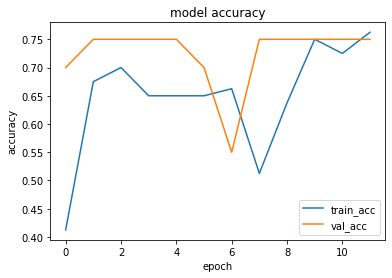

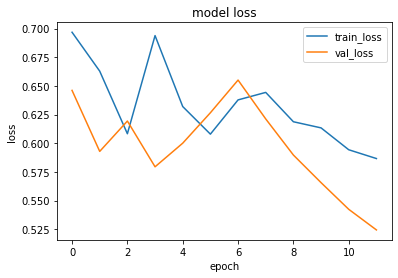

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.53184843]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.61930543]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_2.mov is [[0.653148]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.4420656]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.42123014]]


1it [00:00, 17924.38it/s]


prediction for video control_3.mov is [[0.39309737]]


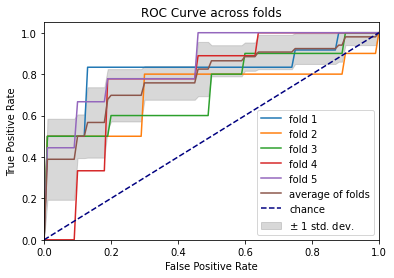

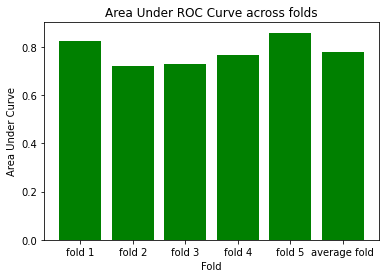

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7025 - accuracy: 0.4375 - precision_45: 0.4286 - recall_45: 0.5526 - val_loss: 0.6334 - val_accuracy: 0.6500 - val_precision_45: 0.6667 - val_recall_45: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6834 - accuracy: 0.5875 - precision_45: 0.5397 - recall_45: 0.8947 - val_loss: 0.6006 - val_accuracy: 0.7500 - val_precision_45: 0.7333 - val_recall_45: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 368ms/step - loss: 0.6373 - accuracy: 0.7750 - precision_45: 0.7632 - recall_45: 0.7632 - val_loss: 0.6226 - val_accuracy: 0.7000 - val_precision_45: 0.8750 - val_recall_45: 0.5833
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6812 - accuracy: 0.6500 - precision_45: 0.6923 - recall_45: 0.4737 - val_loss: 0.5652 - val_accuracy: 0.8500 - val_precision_45: 0.9091 - val_recall_45: 0.8333
Epoch 5/75
3/3 [==============================] - 1s 290ms/step 

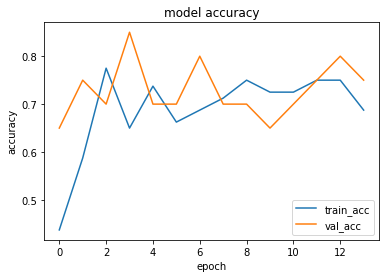

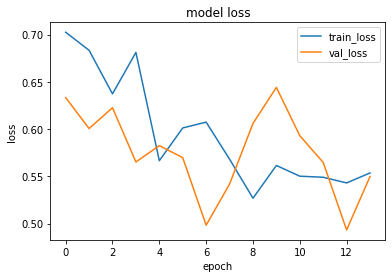

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.44415987]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.46174455]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.54730016]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.4071433]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.39437222]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.37475026]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6764 - accuracy: 0.6250 - precision_46: 0.5962 - recall_46: 0.7750 - val_loss: 0.6484 - val_accuracy: 0.8000 - val_precision_46: 0.8000 - val_recall_46: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6446 - accuracy: 0.6750 - precision_46: 0.8182 - recall_46: 0.4500 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_46: 0.5625 - val_recall_46: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6236 - accuracy: 0.6625 - precision_46: 0.6275 - recall_46: 0.8000 - val_loss: 0.6759 - val_accuracy: 0.7500 - val_precision_46: 0.7273 - val_recall_46: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 303ms/step - loss: 0.5642 - accuracy: 0.7500 - precision_46: 0.8125 - recall_46: 0.6500 - val_loss: 0.6770 - val_accuracy: 0.7500 - val_precision_46: 0.7273 - val_recall_46: 0.8000
Epoch 5/75


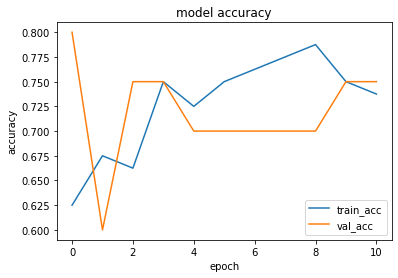

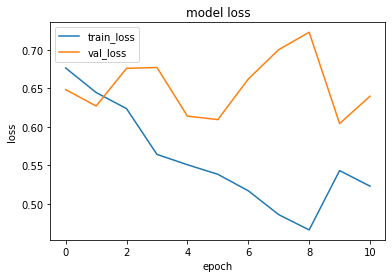

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.54583114]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4918845]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.650259]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.41692883]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.30386418]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.30667847]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6723 - accuracy: 0.5000 - precision_47: 0.5000 - recall_47: 0.7250 - val_loss: 0.7003 - val_accuracy: 0.4500 - val_precision_47: 0.4286 - val_recall_47: 0.3000
Epoch 2/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6693 - accuracy: 0.5125 - precision_47: 0.5161 - recall_47: 0.4000 - val_loss: 0.6591 - val_accuracy: 0.5000 - val_precision_47: 0.5000 - val_recall_47: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6239 - accuracy: 0.5500 - precision_47: 0.5278 - recall_47: 0.9500 - val_loss: 0.6611 - val_accuracy: 0.7000 - val_precision_47: 0.7500 - val_recall_47: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6007 - accuracy: 0.7375 - precision_47: 0.7111 - recall_47: 0.8000 - val_loss: 0.6749 - val_accuracy: 0.7000 - val_precision_47: 0.7500 - val_recall_47: 0.6000
Epoch 5/75


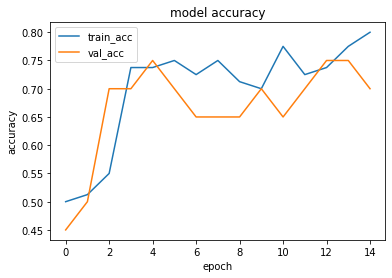

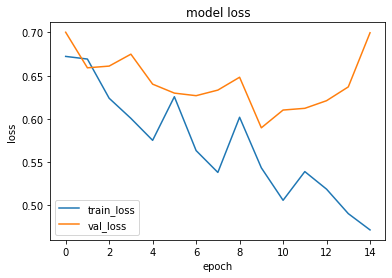

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.19518483]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_3.mov is [[0.58553743]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.712196]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.17063019]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.16422021]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.16348585]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.7027 - accuracy: 0.4125 - precision_48: 0.4444 - recall_48: 0.5854 - val_loss: 0.6725 - val_accuracy: 0.7500 - val_precision_48: 0.6667 - val_recall_48: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6217 - accuracy: 0.7125 - precision_48: 0.6957 - recall_48: 0.7805 - val_loss: 0.6459 - val_accuracy: 0.7000 - val_precision_48: 0.6667 - val_recall_48: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.5937 - accuracy: 0.7000 - precision_48: 0.7742 - recall_48: 0.5854 - val_loss: 0.6745 - val_accuracy: 0.6000 - val_precision_48: 0.5385 - val_recall_48: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.5770 - accuracy: 0.7250 - precision_48: 0.6863 - recall_48: 0.8537 - val_loss: 0.6996 - val_accuracy: 0.6000 - val_precision_48: 0.5385 - val_recall_48: 0.7778
Epoch 5/75


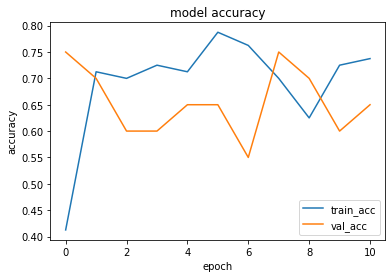

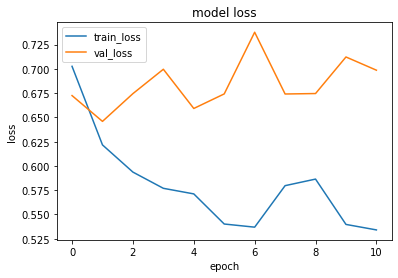

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.291489]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.43104947]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.64502513]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.2281242]]


1it [00:00, 19599.55it/s]


prediction for video control_2.mov is [[0.21977222]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.21677524]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6891 - accuracy: 0.6000 - precision_49: 0.5918 - recall_49: 0.7073 - val_loss: 0.6686 - val_accuracy: 0.5500 - val_precision_49: 0.5000 - val_recall_49: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 410ms/step - loss: 0.7459 - accuracy: 0.5000 - precision_49: 0.5172 - recall_49: 0.3659 - val_loss: 0.6223 - val_accuracy: 0.7500 - val_precision_49: 0.7500 - val_recall_49: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 399ms/step - loss: 0.6492 - accuracy: 0.6875 - precision_49: 0.6739 - recall_49: 0.7561 - val_loss: 0.6305 - val_accuracy: 0.6500 - val_precision_49: 0.5833 - val_recall_49: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 320ms/step - loss: 0.5898 - accuracy: 0.7375 - precision_49: 0.7000 - recall_49: 0.8537 - val_loss: 0.6264 - val_accuracy: 0.6500 - val_precision_49: 0.5833 - val_recall_49: 0.7778
Epoch 5/75


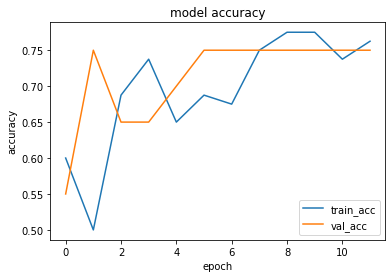

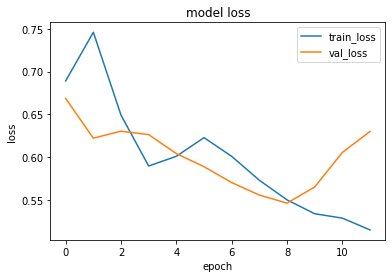

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.39026034]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.7700324]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_2.mov is [[0.8113971]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.09729856]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.08813605]]


1it [00:00, 17848.10it/s]

prediction for video control_3.mov is [[0.08858407]]


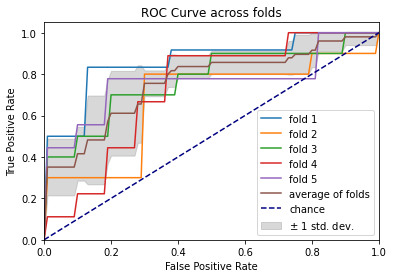

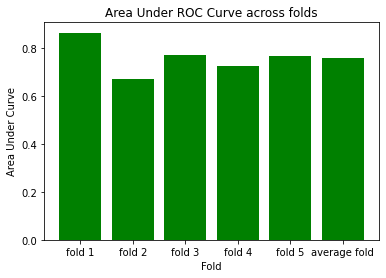

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.7395 - accuracy: 0.4375 - precision_51: 0.3600 - recall_51: 0.2368 - val_loss: 0.6389 - val_accuracy: 0.6000 - val_precision_51: 0.6000 - val_recall_51: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6856 - accuracy: 0.5625 - precision_51: 0.5217 - recall_51: 0.9474 - val_loss: 0.6180 - val_accuracy: 0.6500 - val_precision_51: 0.6471 - val_recall_51: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6479 - accuracy: 0.6250 - precision_51: 0.5769 - recall_51: 0.7895 - val_loss: 0.5898 - val_accuracy: 0.7500 - val_precision_51: 0.7333 - val_recall_51: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6963 - accuracy: 0.6500 - precision_51: 0.6389 - recall_51: 0.6053 - val_loss: 0.6185 - val_accuracy: 0.7000 - val_precision_51: 1.0000 - val_recall_51: 0.5000
Epoch 5/75
3/3 [==============================] - 1s 319ms/step 

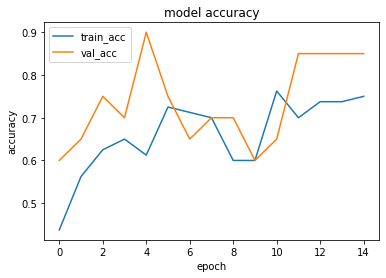

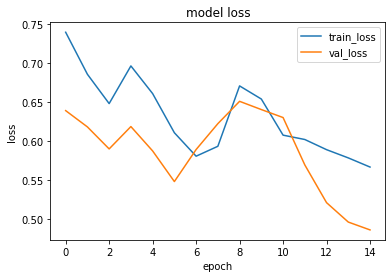

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.45654204]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.44822547]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.51976293]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.43045586]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.41475433]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.414601]]
Epoch 1/75
3/3 [==============================] - 1s 328ms/step - loss: 0.7175 - accuracy: 0.4750 - precision_52: 0.4773 - recall_52: 0.5250 - val_loss: 0.6467 - val_accuracy: 0.7500 - val_precision_52: 0.6667 - val_recall_52: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6670 - accuracy: 0.6125 - precision_52: 0.6286 - recall_52: 0.5500 - val_loss: 0.6719 - val_accuracy: 0.7000 - val_precision_52: 0.7500 - val_recall_52: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 372ms/step - loss: 0.6509 - accuracy: 0.6500 - precision_52: 0.7500 - recall_52: 0.4500 - val_loss: 0.6500 - val_accuracy: 0.7000 - val_precision_52: 0.7000 - val_recall_52: 0.7000
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6132 - accuracy: 0.7250 - precision_52: 0.7250 - recall_52: 0.7250 - val_loss: 0.6001 - val_accuracy: 0.7000 - val_precision_52: 0.6667 - val_recall_52: 0.8000
Epoch 5/75
3/

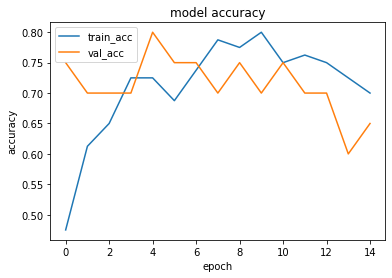

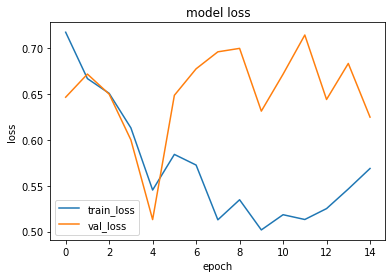

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.4599433]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.5256459]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.5278455]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.3936282]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.35823327]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.35817486]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.7320 - accuracy: 0.6250 - precision_53: 0.5833 - recall_53: 0.8750 - val_loss: 0.6914 - val_accuracy: 0.6000 - val_precision_53: 1.0000 - val_recall_53: 0.2000
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6730 - accuracy: 0.5875 - precision_53: 0.7333 - recall_53: 0.2750 - val_loss: 0.6799 - val_accuracy: 0.6000 - val_precision_53: 1.0000 - val_recall_53: 0.2000
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6408 - accuracy: 0.6875 - precision_53: 0.7778 - recall_53: 0.5250 - val_loss: 0.6630 - val_accuracy: 0.6500 - val_precision_53: 0.8000 - val_recall_53: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6202 - accuracy: 0.6625 - precision_53: 0.7241 - recall_53: 0.5250 - val_loss: 0.6395 - val_accuracy: 0.7000 - val_precision_53: 0.8333 - val_recall_53: 0.5000
Epoch 5/75


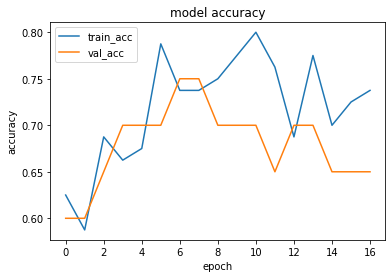

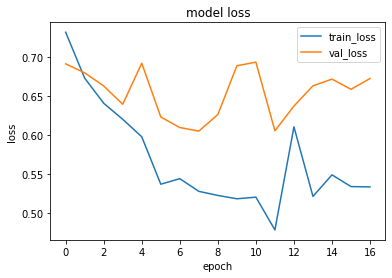

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.26612103]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.52386564]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_2.mov is [[0.5423084]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.23346803]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.22642884]]


1it [00:00, 19691.57it/s]


prediction for video control_3.mov is [[0.22543389]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.7107 - accuracy: 0.4500 - precision_54: 0.4737 - recall_54: 0.6585 - val_loss: 0.6643 - val_accuracy: 0.6000 - val_precision_54: 0.6000 - val_recall_54: 0.3333
Epoch 2/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6491 - accuracy: 0.7250 - precision_54: 0.8276 - recall_54: 0.5854 - val_loss: 0.6656 - val_accuracy: 0.6500 - val_precision_54: 0.5714 - val_recall_54: 0.8889
Epoch 3/75
3/3 [==============================] - 1s 289ms/step - loss: 0.5978 - accuracy: 0.6875 - precision_54: 0.6600 - recall_54: 0.8049 - val_loss: 0.6398 - val_accuracy: 0.7500 - val_precision_54: 0.7000 - val_recall_54: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 298ms/step - loss: 0.5502 - accuracy: 0.7500 - precision_54: 0.7692 - recall_54: 0.7317 - val_loss: 0.6695 - val_accuracy: 0.7000 - val_precision_54: 0.6364 - val_recall_54: 0.7778
Epoch 5/75


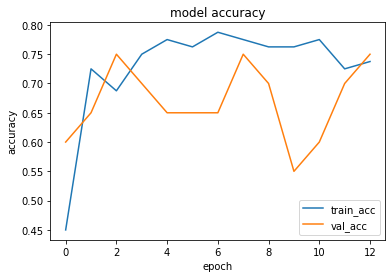

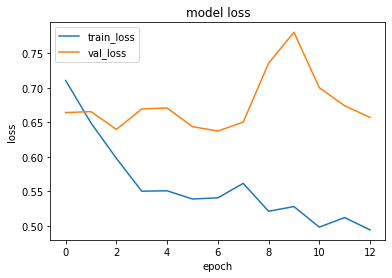

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.29721576]]


1it [00:00, 19508.39it/s]


prediction for video armflapping_3.mov is [[0.6997926]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.7515625]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.19024843]]


1it [00:00, 19152.07it/s]


prediction for video control_2.mov is [[0.20177102]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.19524324]]
Epoch 1/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6655 - accuracy: 0.5875 - precision_55: 0.6176 - recall_55: 0.5122 - val_loss: 0.8105 - val_accuracy: 0.5500 - val_precision_55: 0.5000 - val_recall_55: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6899 - accuracy: 0.6500 - precision_55: 0.6140 - recall_55: 0.8537 - val_loss: 0.6472 - val_accuracy: 0.6500 - val_precision_55: 0.6000 - val_recall_55: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6611 - accuracy: 0.6375 - precision_55: 0.6579 - recall_55: 0.6098 - val_loss: 0.5918 - val_accuracy: 0.8000 - val_precision_55: 0.8571 - val_recall_55: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 366ms/step - loss: 0.6057 - accuracy: 0.7125 - precision_55: 0.7143 - recall_55: 0.7317 - val_loss: 0.5859 - val_accuracy: 0.7500 - val_precision_55: 0.7000 - val_recall_55: 0.7778
Epoch 5/75


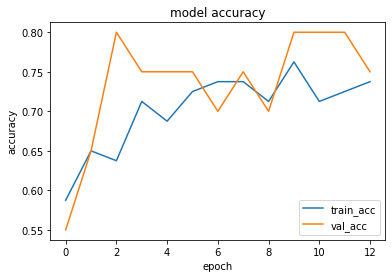

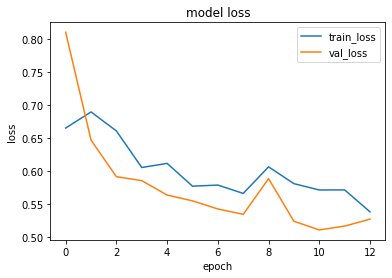

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.5743021]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.60196304]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_2.mov is [[0.6790005]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.30538964]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.24943683]]


1it [00:00, 18477.11it/s]

prediction for video control_3.mov is [[0.24792013]]


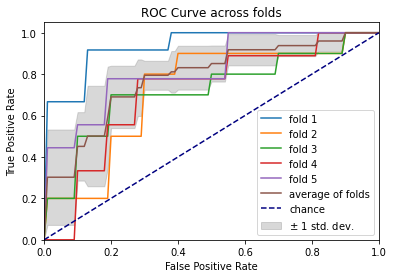

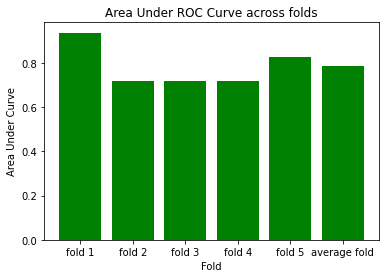

In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.7452 - accuracy: 0.4500 - precision_57: 0.3636 - recall_57: 0.2105 - val_loss: 0.6597 - val_accuracy: 0.7500 - val_precision_57: 0.7333 - val_recall_57: 0.9167
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6852 - accuracy: 0.5125 - precision_57: 0.4930 - recall_57: 0.9211 - val_loss: 0.6127 - val_accuracy: 0.7000 - val_precision_57: 0.6875 - val_recall_57: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6567 - accuracy: 0.7000 - precision_57: 0.6591 - recall_57: 0.7632 - val_loss: 0.6282 - val_accuracy: 0.7500 - val_precision_57: 0.8182 - val_recall_57: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 383ms/step - loss: 0.6563 - accuracy: 0.6625 - precision_57: 0.6774 - recall_57: 0.5526 - val_loss: 0.6091 - val_accuracy: 0.8000 - val_precision_57: 0.9000 - val_recall_57: 0.7500
Epoch 5/75
3/3 [==============================] - 1s 299ms/step 

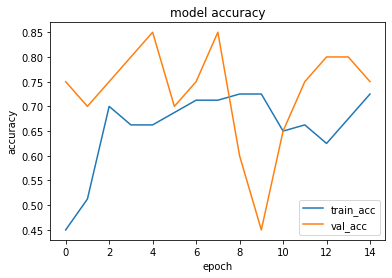

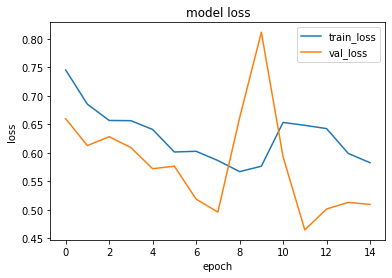

1it [00:00, 13530.01it/s]


prediction for video armflapping_1.mov is [[0.45824528]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5067901]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.56091905]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.35267937]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.33166012]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.33284077]]
Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.7479 - accuracy: 0.4625 - precision_58: 0.4444 - recall_58: 0.3000 - val_loss: 0.6707 - val_accuracy: 0.5500 - val_precision_58: 0.5263 - val_recall_58: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6840 - accuracy: 0.5375 - precision_58: 0.5200 - recall_58: 0.9750 - val_loss: 0.6471 - val_accuracy: 0.5000 - val_precision_58: 0.5000 - val_recall_58: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6256 - accuracy: 0.6500 - precision_58: 0.6250 - recall_58: 0.7500 - val_loss: 0.6256 - val_accuracy: 0.7500 - val_precision_58: 0.6923 - val_recall_58: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6020 - accuracy: 0.7125 - precision_58: 0.7073 - recall_58: 0.7250 - val_loss: 0.5708 - val_accuracy: 0.7000 - val_precision_58: 0.6429 - val_recall_58: 0.9000
Epoch 5/75


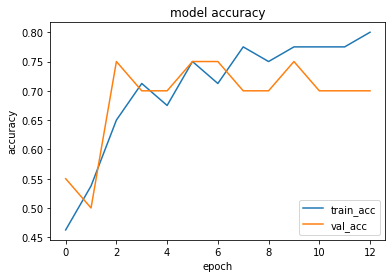

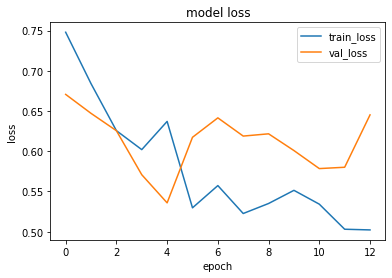

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.614861]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.33049625]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.76863825]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.4082551]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.24745989]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.25751936]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.7033 - accuracy: 0.4625 - precision_59: 0.4769 - recall_59: 0.7750 - val_loss: 0.6828 - val_accuracy: 0.5500 - val_precision_59: 0.5294 - val_recall_59: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6576 - accuracy: 0.5500 - precision_59: 0.5370 - recall_59: 0.7250 - val_loss: 0.6911 - val_accuracy: 0.7500 - val_precision_59: 0.7778 - val_recall_59: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6000 - accuracy: 0.7750 - precision_59: 0.7619 - recall_59: 0.8000 - val_loss: 0.6698 - val_accuracy: 0.6500 - val_precision_59: 0.6667 - val_recall_59: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6361 - accuracy: 0.7375 - precision_59: 0.6863 - recall_59: 0.8750 - val_loss: 0.6510 - val_accuracy: 0.7000 - val_precision_59: 0.7500 - val_recall_59: 0.6000
Epoch 5/75


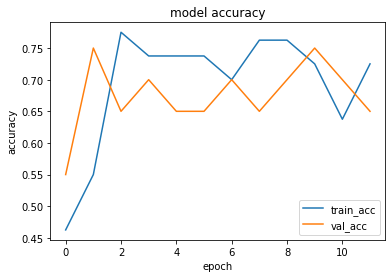

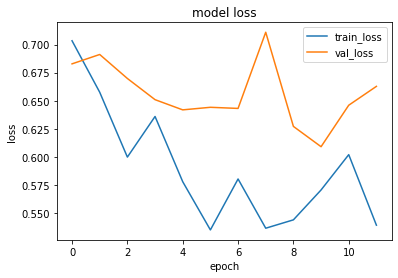

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.43742684]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.47740948]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.6078134]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.31831068]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.27183056]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.2539365]]
Epoch 1/75
3/3 [==============================] - 1s 309ms/step - loss: 0.7041 - accuracy: 0.5375 - precision_60: 0.5312 - recall_60: 0.8293 - val_loss: 0.6810 - val_accuracy: 0.7500 - val_precision_60: 0.6667 - val_recall_60: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6615 - accuracy: 0.6750 - precision_60: 0.7419 - recall_60: 0.5610 - val_loss: 0.6610 - val_accuracy: 0.6000 - val_precision_60: 0.5714 - val_recall_60: 0.4444
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.5936 - accuracy: 0.8000 - precision_60: 0.8378 - recall_60: 0.7561 - val_loss: 0.6836 - val_accuracy: 0.7000 - val_precision_60: 0.6364 - val_recall_60: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6017 - accuracy: 0.7125 - precision_60: 0.6957 - recall_60: 0.7805 - val_loss: 0.6646 - val_accuracy: 0.6500 - val_precision_60: 0.5833 - val_recall_60: 0.7778
Epoch 5/75
3

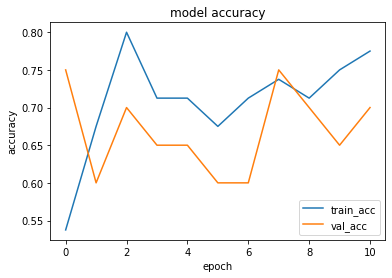

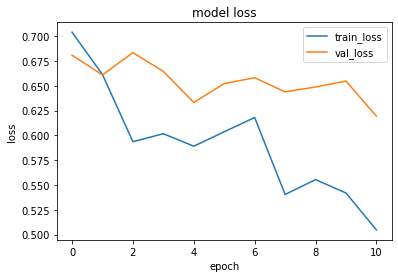

1it [00:00, 13148.29it/s]


prediction for video armflapping_1.mov is [[0.52551514]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.6047593]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.63987803]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.43997088]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.3941569]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.39323717]]
Epoch 1/75
3/3 [==============================] - 1s 334ms/step - loss: 0.6999 - accuracy: 0.5625 - precision_61: 0.6071 - recall_61: 0.4146 - val_loss: 0.7271 - val_accuracy: 0.4500 - val_precision_61: 0.4500 - val_recall_61: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6659 - accuracy: 0.6000 - precision_61: 0.5616 - recall_61: 1.0000 - val_loss: 0.6138 - val_accuracy: 0.7000 - val_precision_61: 0.8000 - val_recall_61: 0.4444
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6811 - accuracy: 0.5875 - precision_61: 0.7222 - recall_61: 0.3171 - val_loss: 0.5750 - val_accuracy: 0.8000 - val_precision_61: 0.7778 - val_recall_61: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6189 - accuracy: 0.7250 - precision_61: 0.7568 - recall_61: 0.6829 - val_loss: 0.5773 - val_accuracy: 0.7000 - val_precision_61: 0.6364 - val_recall_61: 0.7778
Epoch 5/75


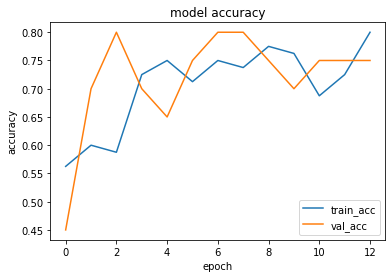

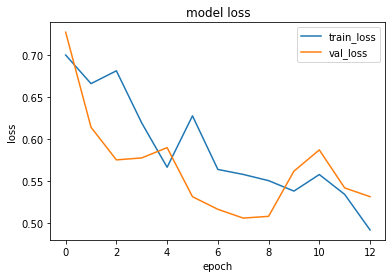

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.57978934]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.69816506]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.76521134]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.3202598]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.23724231]]


1it [00:00, 17331.83it/s]

prediction for video control_3.mov is [[0.20404613]]


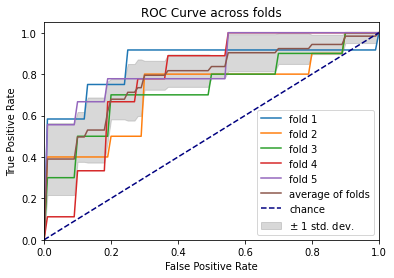

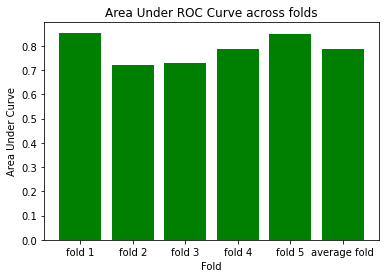

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6777 - accuracy: 0.5625 - precision_63: 0.5429 - recall_63: 0.5000 - val_loss: 0.6200 - val_accuracy: 0.6000 - val_precision_63: 0.7000 - val_recall_63: 0.5833
Epoch 2/75
3/3 [==============================] - 1s 312ms/step - loss: 0.5996 - accuracy: 0.7500 - precision_63: 0.7368 - recall_63: 0.7368 - val_loss: 0.8284 - val_accuracy: 0.6000 - val_precision_63: 0.7000 - val_recall_63: 0.5833
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6430 - accuracy: 0.7125 - precision_63: 0.7143 - recall_63: 0.6579 - val_loss: 0.8935 - val_accuracy: 0.4000 - val_precision_63: 0.0000e+00 - val_recall_63: 0.0000e+00
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.7016 - accuracy: 0.5625 - precision_63: 0.5789 - recall_63: 0.2895 - val_loss: 0.6516 - val_accuracy: 0.6000 - val_precision_63: 0.6000 - val_recall_63: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 288

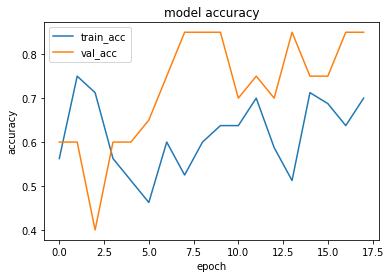

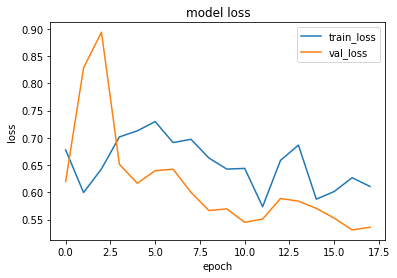

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.41652045]]


1it [00:00, 18641.35it/s]


prediction for video armflapping_3.mov is [[0.4491013]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.44515508]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.41572863]]


1it [00:00, 15477.14it/s]


prediction for video control_2.mov is [[0.4023837]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.40964875]]
Epoch 1/75
3/3 [==============================] - 1s 329ms/step - loss: 0.6934 - accuracy: 0.4875 - precision_64: 0.4925 - recall_64: 0.8250 - val_loss: 0.6897 - val_accuracy: 0.5500 - val_precision_64: 0.6000 - val_recall_64: 0.3000
Epoch 2/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6282 - accuracy: 0.6875 - precision_64: 0.7586 - recall_64: 0.5500 - val_loss: 0.5838 - val_accuracy: 0.8000 - val_precision_64: 0.7143 - val_recall_64: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 331ms/step - loss: 0.5740 - accuracy: 0.7125 - precision_64: 0.6809 - recall_64: 0.8000 - val_loss: 0.5893 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6129 - accuracy: 0.7125 - precision_64: 0.7576 - recall_64: 0.6250 - val_loss: 0.6239 - val_accuracy: 0.7500 - val_precision_64: 0.7273 - val_recall_64: 0.8000
Epoch 5/75


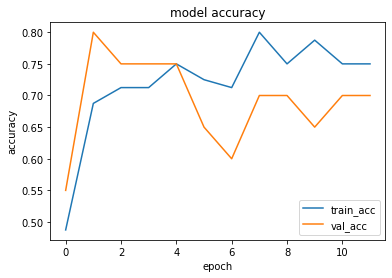

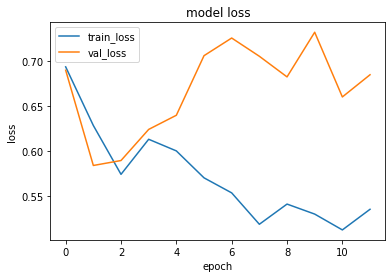

1it [00:00, 12336.19it/s]


prediction for video armflapping_1.mov is [[0.5742741]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.1737982]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.6178754]]


1it [00:00, 11618.57it/s]


prediction for video control_1.mov is [[0.46571928]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.35609007]]


1it [00:00, 18808.54it/s]


prediction for video control_3.mov is [[0.37443006]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6860 - accuracy: 0.5000 - precision_65: 0.5000 - recall_65: 0.5250 - val_loss: 0.6705 - val_accuracy: 0.6000 - val_precision_65: 0.5625 - val_recall_65: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6505 - accuracy: 0.6000 - precision_65: 0.5833 - recall_65: 0.7000 - val_loss: 0.6227 - val_accuracy: 0.7000 - val_precision_65: 0.7000 - val_recall_65: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6263 - accuracy: 0.7000 - precision_65: 0.6739 - recall_65: 0.7750 - val_loss: 0.6502 - val_accuracy: 0.6500 - val_precision_65: 0.6667 - val_recall_65: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 314ms/step - loss: 0.6319 - accuracy: 0.7125 - precision_65: 0.7297 - recall_65: 0.6750 - val_loss: 0.6545 - val_accuracy: 0.6500 - val_precision_65: 0.8000 - val_recall_65: 0.4000
Epoch 5/75


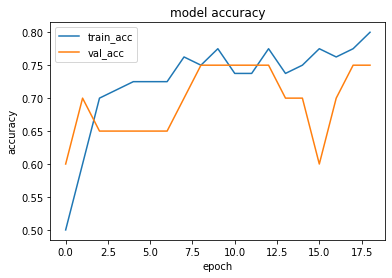

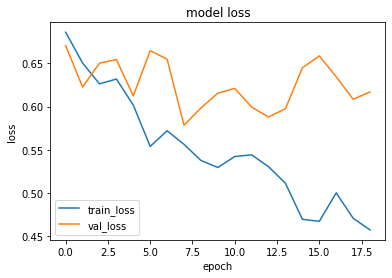

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.45749852]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.64982224]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6798755]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.24007931]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.22364679]]


1it [00:00, 18558.87it/s]


prediction for video control_3.mov is [[0.22441134]]
Epoch 1/75
3/3 [==============================] - 1s 336ms/step - loss: 0.7251 - accuracy: 0.4625 - precision_66: 0.4792 - recall_66: 0.5610 - val_loss: 0.6883 - val_accuracy: 0.6500 - val_precision_66: 0.5714 - val_recall_66: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6461 - accuracy: 0.7250 - precision_66: 0.6939 - recall_66: 0.8293 - val_loss: 0.6670 - val_accuracy: 0.6000 - val_precision_66: 0.5385 - val_recall_66: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 334ms/step - loss: 0.5899 - accuracy: 0.7250 - precision_66: 0.6863 - recall_66: 0.8537 - val_loss: 0.7039 - val_accuracy: 0.6000 - val_precision_66: 0.5385 - val_recall_66: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6744 - accuracy: 0.7125 - precision_66: 0.7500 - recall_66: 0.6585 - val_loss: 0.6910 - val_accuracy: 0.6000 - val_precision_66: 0.5556 - val_recall_66: 0.5556
Epoch 5/75


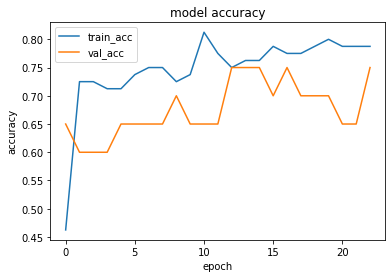

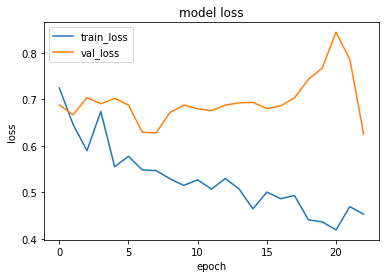

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.3537776]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_3.mov is [[0.33556253]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.8612334]]


1it [00:00, 12336.19it/s]


prediction for video control_1.mov is [[0.25198415]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.24477443]]


1it [00:00, 8630.26it/s]


prediction for video control_3.mov is [[0.23463795]]
Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.7512 - accuracy: 0.5500 - precision_67: 0.5373 - recall_67: 0.8780 - val_loss: 0.6541 - val_accuracy: 0.7000 - val_precision_67: 0.8000 - val_recall_67: 0.4444
Epoch 2/75
3/3 [==============================] - 1s 400ms/step - loss: 0.6762 - accuracy: 0.6500 - precision_67: 0.7600 - recall_67: 0.4634 - val_loss: 0.6392 - val_accuracy: 0.7000 - val_precision_67: 0.7143 - val_recall_67: 0.5556
Epoch 3/75
3/3 [==============================] - 1s 325ms/step - loss: 0.6650 - accuracy: 0.6750 - precision_67: 0.7027 - recall_67: 0.6341 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_67: 0.6667 - val_recall_67: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 332ms/step - loss: 0.6150 - accuracy: 0.7250 - precision_67: 0.7436 - recall_67: 0.7073 - val_loss: 0.5855 - val_accuracy: 0.7500 - val_precision_67: 0.7000 - val_recall_67: 0.7778
Epoch 5/75


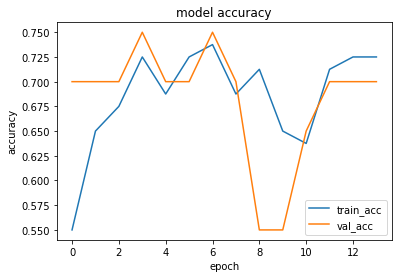

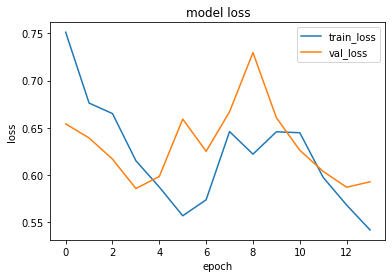

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5166733]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.48119068]]


1it [00:00, 12985.46it/s]


prediction for video armflapping_2.mov is [[0.7255149]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.2624573]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.23468]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.22758612]]


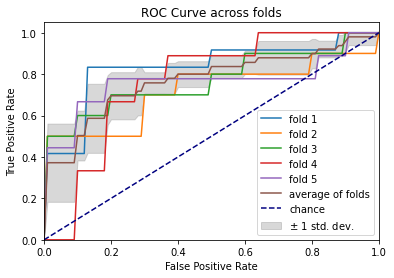

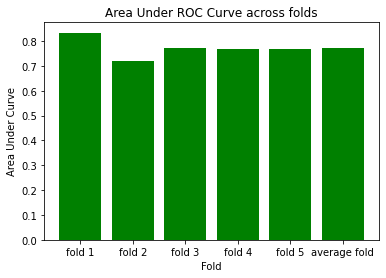

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6986 - accuracy: 0.5000 - precision_69: 0.4643 - recall_69: 0.3421 - val_loss: 0.6204 - val_accuracy: 0.7000 - val_precision_69: 0.7143 - val_recall_69: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6119 - accuracy: 0.7250 - precision_69: 0.8077 - recall_69: 0.5526 - val_loss: 0.7237 - val_accuracy: 0.4000 - val_precision_69: 0.0000e+00 - val_recall_69: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6460 - accuracy: 0.6625 - precision_69: 0.7200 - recall_69: 0.4737 - val_loss: 0.5220 - val_accuracy: 0.7000 - val_precision_69: 0.6875 - val_recall_69: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6075 - accuracy: 0.7000 - precision_69: 0.6346 - recall_69: 0.8684 - val_loss: 0.7048 - val_accuracy: 0.7000 - val_precision_69: 0.8750 - val_recall_69: 0.5833
Epoch 5/75
3/3 [==============================] - 1s 377

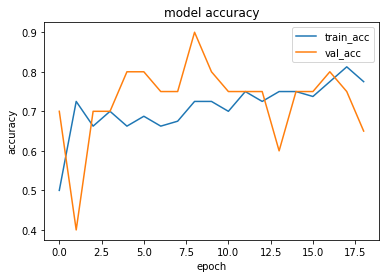

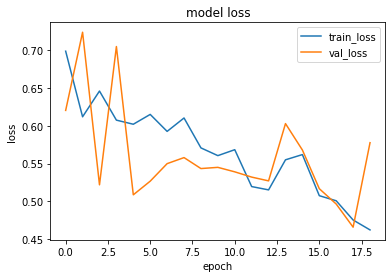

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.45960683]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.5831384]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.6340275]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.2620527]]


1it [00:00, 19691.57it/s]


prediction for video control_2.mov is [[0.20442802]]


1it [00:00, 16912.52it/s]


prediction for video control_3.mov is [[0.230519]]
Epoch 1/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6964 - accuracy: 0.4750 - precision_70: 0.4833 - recall_70: 0.7250 - val_loss: 0.6572 - val_accuracy: 0.5500 - val_precision_70: 0.5263 - val_recall_70: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 326ms/step - loss: 0.6523 - accuracy: 0.6000 - precision_70: 0.5769 - recall_70: 0.7500 - val_loss: 0.6918 - val_accuracy: 0.7000 - val_precision_70: 0.7500 - val_recall_70: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6004 - accuracy: 0.7375 - precision_70: 0.7111 - recall_70: 0.8000 - val_loss: 0.6640 - val_accuracy: 0.6500 - val_precision_70: 0.6154 - val_recall_70: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.5927 - accuracy: 0.7750 - precision_70: 0.7750 - recall_70: 0.7750 - val_loss: 0.6333 - val_accuracy: 0.7000 - val_precision_70: 0.6667 - val_recall_70: 0.8000
Epoch 5/75
3/

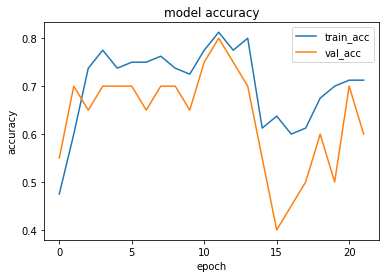

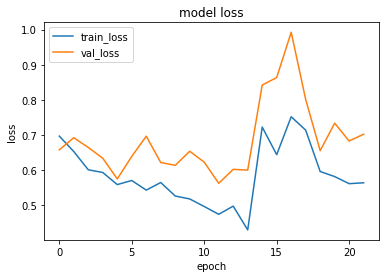

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.44643593]]


1it [00:00, 17050.02it/s]


prediction for video armflapping_3.mov is [[0.64729404]]


1it [00:00, 12446.01it/s]


prediction for video armflapping_2.mov is [[0.58038944]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.43572766]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.43143433]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.43070984]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6968 - accuracy: 0.5125 - precision_71: 0.5106 - recall_71: 0.6000 - val_loss: 0.6343 - val_accuracy: 0.5000 - val_precision_71: 0.5000 - val_recall_71: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6314 - accuracy: 0.5750 - precision_71: 0.5455 - recall_71: 0.9000 - val_loss: 0.6348 - val_accuracy: 0.7500 - val_precision_71: 0.7778 - val_recall_71: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6103 - accuracy: 0.7250 - precision_71: 0.6731 - recall_71: 0.8750 - val_loss: 0.5955 - val_accuracy: 0.7000 - val_precision_71: 0.7500 - val_recall_71: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 291ms/step - loss: 0.5500 - accuracy: 0.7500 - precision_71: 0.7381 - recall_71: 0.7750 - val_loss: 0.6252 - val_accuracy: 0.6500 - val_precision_71: 0.6667 - val_recall_71: 0.6000
Epoch 5/75


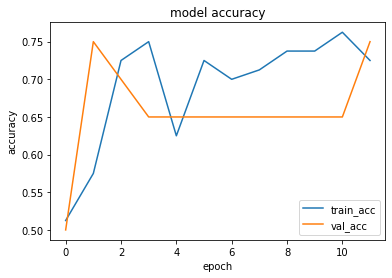

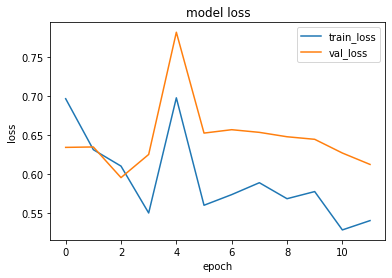

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.41811812]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.5607131]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.61526716]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.28738043]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.22560719]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.21811512]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6648 - accuracy: 0.5625 - precision_72: 0.5652 - recall_72: 0.6341 - val_loss: 0.7898 - val_accuracy: 0.5500 - val_precision_72: 0.5000 - val_recall_72: 0.8889
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.7226 - accuracy: 0.6125 - precision_72: 0.5926 - recall_72: 0.7805 - val_loss: 0.7495 - val_accuracy: 0.5500 - val_precision_72: 0.0000e+00 - val_recall_72: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 1s 322ms/step - loss: 0.7546 - accuracy: 0.4875 - precision_72: 0.0000e+00 - recall_72: 0.0000e+00 - val_loss: 0.6918 - val_accuracy: 0.5500 - val_precision_72: 0.5000 - val_recall_72: 0.4444
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6448 - accuracy: 0.6125 - precision_72: 0.5926 - recall_72: 0.7805 - val_loss: 0.7806 - val_accuracy: 0.4500 - val_precision_72: 0.4500 - val_recall_72: 1.

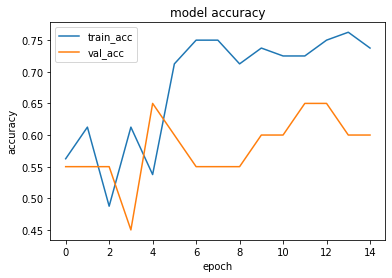

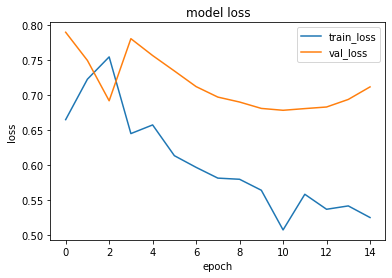

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.3554687]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.5284035]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5755383]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.25686318]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.2557992]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.25377512]]
Epoch 1/75
3/3 [==============================] - 1s 302ms/step - loss: 0.7168 - accuracy: 0.5500 - precision_73: 0.5362 - recall_73: 0.9024 - val_loss: 0.6516 - val_accuracy: 0.7000 - val_precision_73: 0.6667 - val_recall_73: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6659 - accuracy: 0.6625 - precision_73: 0.6842 - recall_73: 0.6341 - val_loss: 0.6319 - val_accuracy: 0.7500 - val_precision_73: 0.7500 - val_recall_73: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6442 - accuracy: 0.7000 - precision_73: 0.7073 - recall_73: 0.7073 - val_loss: 0.5874 - val_accuracy: 0.7000 - val_precision_73: 0.6364 - val_recall_73: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6658 - accuracy: 0.6000 - precision_73: 0.5738 - recall_73: 0.8537 - val_loss: 0.5855 - val_accuracy: 0.7000 - val_precision_73: 0.6364 - val_recall_73: 0.7778
Epoch 5/75


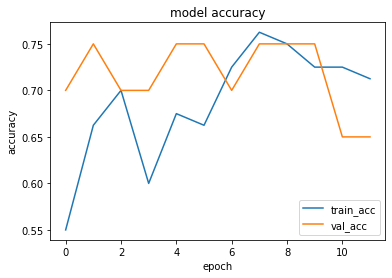

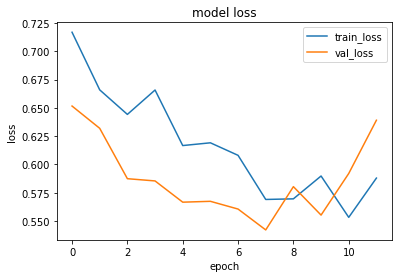

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.56691265]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.67129964]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_2.mov is [[0.7045362]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.23533633]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.18763563]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.18535686]]


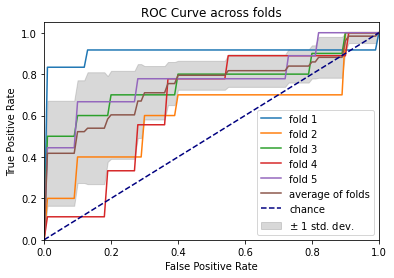

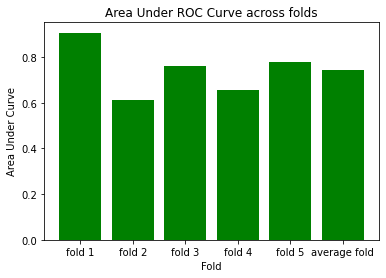

In [29]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 375ms/step - loss: 0.7016 - accuracy: 0.4250 - precision_75: 0.4167 - recall_75: 0.5263 - val_loss: 0.6232 - val_accuracy: 0.6500 - val_precision_75: 0.6471 - val_recall_75: 0.9167
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6643 - accuracy: 0.6250 - precision_75: 0.5714 - recall_75: 0.8421 - val_loss: 0.5964 - val_accuracy: 0.8000 - val_precision_75: 0.7857 - val_recall_75: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6245 - accuracy: 0.7125 - precision_75: 0.7143 - recall_75: 0.6579 - val_loss: 0.5521 - val_accuracy: 0.7000 - val_precision_75: 0.6875 - val_recall_75: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6025 - accuracy: 0.6750 - precision_75: 0.6364 - recall_75: 0.7368 - val_loss: 0.5605 - val_accuracy: 0.6500 - val_precision_75: 0.6667 - val_recall_75: 0.8333
Epoch 5/75
3/3 [==============================] - 1s 299ms/step 

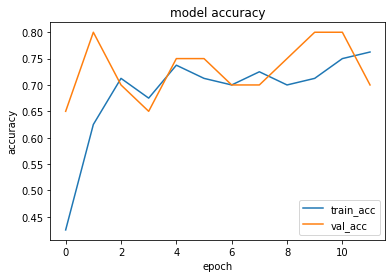

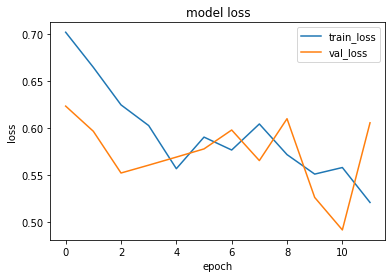

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.51027733]]


1it [00:00, 19691.57it/s]


prediction for video armflapping_3.mov is [[0.49464992]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.51748854]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.4780463]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4593711]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.45175716]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.7072 - accuracy: 0.4750 - precision_76: 0.4762 - recall_76: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.4500 - val_precision_76: 0.4706 - val_recall_76: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6743 - accuracy: 0.5500 - precision_76: 0.5294 - recall_76: 0.9000 - val_loss: 0.6640 - val_accuracy: 0.7500 - val_precision_76: 0.7273 - val_recall_76: 0.8000
Epoch 3/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6110 - accuracy: 0.7000 - precision_76: 0.6905 - recall_76: 0.7250 - val_loss: 0.7013 - val_accuracy: 0.7000 - val_precision_76: 0.8333 - val_recall_76: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 375ms/step - loss: 0.5881 - accuracy: 0.7375 - precision_76: 0.8065 - recall_76: 0.6250 - val_loss: 0.6329 - val_accuracy: 0.7500 - val_precision_76: 0.8571 - val_recall_76: 0.6000
Epoch 5/75


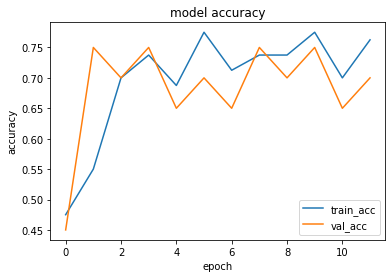

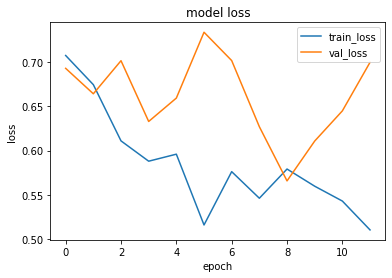

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.52847004]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.48805624]]


1it [00:00, 12787.51it/s]


prediction for video armflapping_2.mov is [[0.61536235]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.46301937]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.39926976]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.3986642]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.7120 - accuracy: 0.4375 - precision_77: 0.4545 - recall_77: 0.6250 - val_loss: 0.6573 - val_accuracy: 0.7000 - val_precision_77: 0.7500 - val_recall_77: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6597 - accuracy: 0.6750 - precision_77: 0.7059 - recall_77: 0.6000 - val_loss: 0.6315 - val_accuracy: 0.6500 - val_precision_77: 0.6364 - val_recall_77: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6779 - accuracy: 0.6625 - precision_77: 0.6102 - recall_77: 0.9000 - val_loss: 0.6414 - val_accuracy: 0.7000 - val_precision_77: 0.6667 - val_recall_77: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6062 - accuracy: 0.6875 - precision_77: 0.6471 - recall_77: 0.8250 - val_loss: 0.6389 - val_accuracy: 0.6500 - val_precision_77: 0.8000 - val_recall_77: 0.4000
Epoch 5/75
3

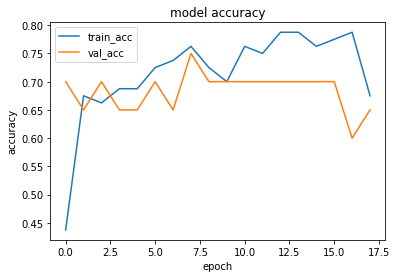

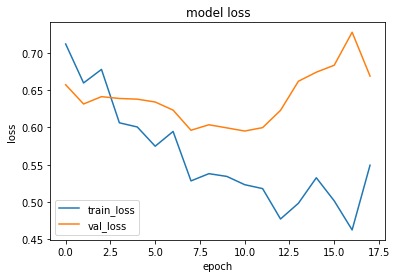

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.27746618]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.6261865]]


1it [00:00, 15477.14it/s]


prediction for video armflapping_2.mov is [[0.78665197]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.24179733]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.23253614]]


1it [00:00, 17331.83it/s]


prediction for video control_3.mov is [[0.23236999]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6846 - accuracy: 0.5125 - precision_78: 0.5167 - recall_78: 0.7561 - val_loss: 0.6913 - val_accuracy: 0.5000 - val_precision_78: 0.4737 - val_recall_78: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 300ms/step - loss: 0.6100 - accuracy: 0.6750 - precision_78: 0.6471 - recall_78: 0.8049 - val_loss: 0.6356 - val_accuracy: 0.7000 - val_precision_78: 0.6667 - val_recall_78: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6024 - accuracy: 0.7250 - precision_78: 0.7111 - recall_78: 0.7805 - val_loss: 0.6743 - val_accuracy: 0.7000 - val_precision_78: 0.6667 - val_recall_78: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 296ms/step - loss: 0.5268 - accuracy: 0.7375 - precision_78: 0.7632 - recall_78: 0.7073 - val_loss: 0.6203 - val_accuracy: 0.7000 - val_precision_78: 0.7143 - val_recall_78: 0.5556
Epoch 5/75


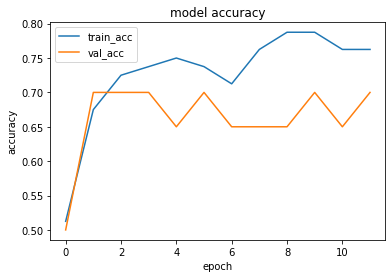

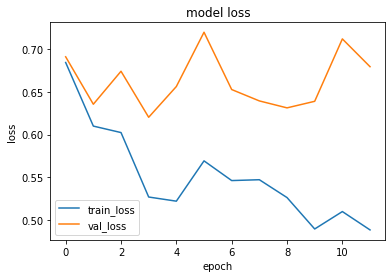

1it [00:00, 12826.62it/s]


prediction for video armflapping_1.mov is [[0.36522555]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.6655581]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.73302877]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.27713776]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.2664569]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.26481783]]
Epoch 1/75
3/3 [==============================] - 1s 326ms/step - loss: 0.7121 - accuracy: 0.5500 - precision_79: 0.5556 - recall_79: 0.6098 - val_loss: 0.5922 - val_accuracy: 0.7500 - val_precision_79: 0.7000 - val_recall_79: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6522 - accuracy: 0.6250 - precision_79: 0.5902 - recall_79: 0.8780 - val_loss: 0.5683 - val_accuracy: 0.7000 - val_precision_79: 0.6364 - val_recall_79: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6140 - accuracy: 0.7125 - precision_79: 0.6957 - recall_79: 0.7805 - val_loss: 0.5388 - val_accuracy: 0.7500 - val_precision_79: 0.7000 - val_recall_79: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6120 - accuracy: 0.7375 - precision_79: 0.7778 - recall_79: 0.6829 - val_loss: 0.5358 - val_accuracy: 0.7500 - val_precision_79: 0.7000 - val_recall_79: 0.7778
Epoch 5/75


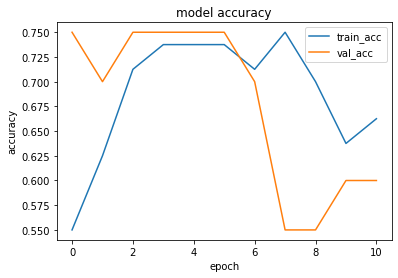

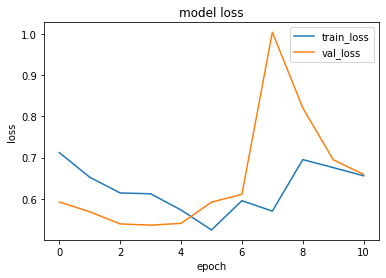

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.48406765]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5463126]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5191667]]


1it [00:00, 16644.06it/s]


prediction for video control_1.mov is [[0.3454194]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.33368117]]


1it [00:00, 18641.35it/s]


prediction for video control_3.mov is [[0.33478284]]


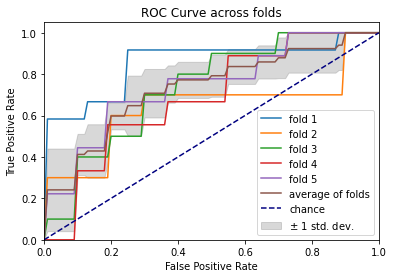

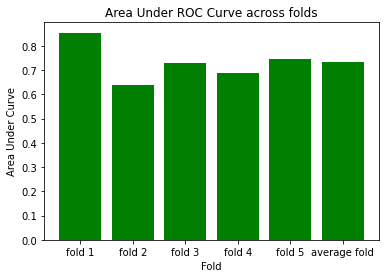

In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6997 - accuracy: 0.5125 - precision_81: 0.4909 - recall_81: 0.7105 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_81: 0.7692 - val_recall_81: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6411 - accuracy: 0.7000 - precision_81: 0.6458 - recall_81: 0.8158 - val_loss: 0.5650 - val_accuracy: 0.6500 - val_precision_81: 0.6471 - val_recall_81: 0.9167
Epoch 3/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6495 - accuracy: 0.6625 - precision_81: 0.6078 - recall_81: 0.8158 - val_loss: 0.5779 - val_accuracy: 0.8000 - val_precision_81: 0.8333 - val_recall_81: 0.8333
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.5929 - accuracy: 0.7500 - precision_81: 0.7812 - recall_81: 0.6579 - val_loss: 0.6385 - val_accuracy: 0.7000 - val_precision_81: 1.0000 - val_recall_81: 0.5000
Epoch 5/75
3/3 [==============================] - 1s 297ms/step 

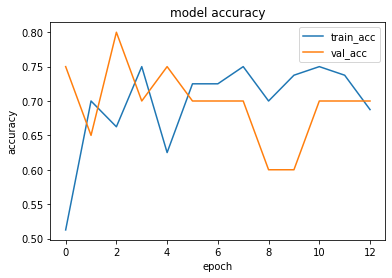

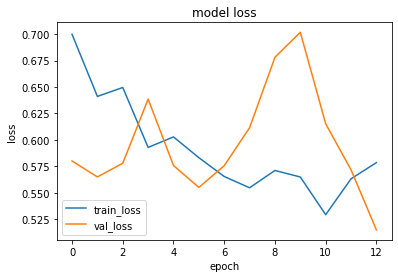

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.3834084]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.43287188]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_2.mov is [[0.5338435]]


1it [00:00, 18477.11it/s]


prediction for video control_1.mov is [[0.34345484]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.33228588]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.31979573]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.7069 - accuracy: 0.4375 - precision_82: 0.4444 - recall_82: 0.5000 - val_loss: 0.6650 - val_accuracy: 0.4500 - val_precision_82: 0.4706 - val_recall_82: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6073 - accuracy: 0.7250 - precision_82: 0.6800 - recall_82: 0.8500 - val_loss: 0.7365 - val_accuracy: 0.7500 - val_precision_82: 0.7778 - val_recall_82: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6121 - accuracy: 0.7250 - precision_82: 0.6731 - recall_82: 0.8750 - val_loss: 0.6363 - val_accuracy: 0.7000 - val_precision_82: 0.6667 - val_recall_82: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6384 - accuracy: 0.7375 - precision_82: 0.7209 - recall_82: 0.7750 - val_loss: 0.6332 - val_accuracy: 0.8000 - val_precision_82: 0.7500 - val_recall_82: 0.9000
Epoch 5/75


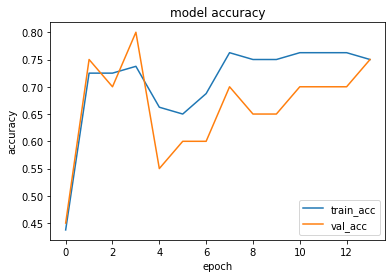

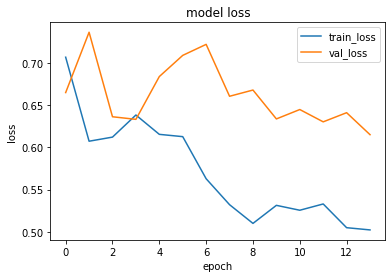

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.5833595]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.39991355]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_2.mov is [[0.64432675]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.47096157]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.3024863]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.33424896]]
Epoch 1/75
3/3 [==============================] - 1s 300ms/step - loss: 0.7225 - accuracy: 0.4750 - precision_83: 0.4643 - recall_83: 0.3250 - val_loss: 0.6813 - val_accuracy: 0.5000 - val_precision_83: 0.5000 - val_recall_83: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6905 - accuracy: 0.5250 - precision_83: 0.5135 - recall_83: 0.9500 - val_loss: 0.6681 - val_accuracy: 0.5000 - val_precision_83: 0.5000 - val_recall_83: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 373ms/step - loss: 0.6526 - accuracy: 0.7000 - precision_83: 0.6379 - recall_83: 0.9250 - val_loss: 0.6773 - val_accuracy: 0.6500 - val_precision_83: 0.8000 - val_recall_83: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6489 - accuracy: 0.6750 - precision_83: 0.6750 - recall_83: 0.6750 - val_loss: 0.6605 - val_accuracy: 0.7000 - val_precision_83: 0.8333 - val_recall_83: 0.5000
Epoch 5/75


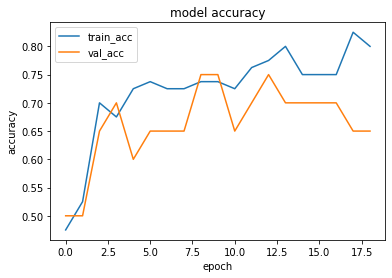

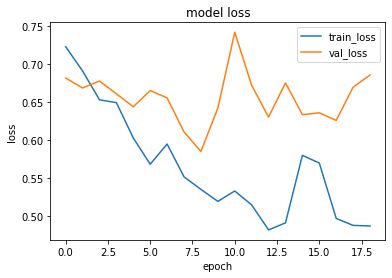

1it [00:00, 21732.15it/s]


prediction for video armflapping_1.mov is [[0.25405836]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.6124813]]


1it [00:00, 19508.39it/s]


prediction for video armflapping_2.mov is [[0.27721316]]


1it [00:00, 18808.54it/s]


prediction for video control_1.mov is [[0.24600771]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.24351472]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.24323049]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6768 - accuracy: 0.4625 - precision_84: 0.4808 - recall_84: 0.6098 - val_loss: 0.6636 - val_accuracy: 0.7500 - val_precision_84: 0.7000 - val_recall_84: 0.7778
Epoch 2/75
3/3 [==============================] - 1s 295ms/step - loss: 0.5980 - accuracy: 0.7250 - precision_84: 0.7317 - recall_84: 0.7317 - val_loss: 0.7574 - val_accuracy: 0.6000 - val_precision_84: 0.5385 - val_recall_84: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 290ms/step - loss: 0.5994 - accuracy: 0.7375 - precision_84: 0.7000 - recall_84: 0.8537 - val_loss: 0.9109 - val_accuracy: 0.5500 - val_precision_84: 0.5000 - val_recall_84: 0.1111
Epoch 4/75
3/3 [==============================] - 1s 369ms/step - loss: 0.8210 - accuracy: 0.5875 - precision_84: 0.9000 - recall_84: 0.2195 - val_loss: 0.6843 - val_accuracy: 0.5500 - val_precision_84: 0.5000 - val_recall_84: 0.4444
Epoch 5/75


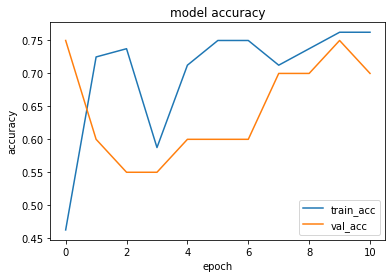

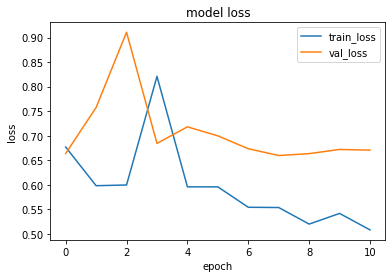

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.36546353]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6624353]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6712197]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.29811934]]


1it [00:00, 19152.07it/s]


prediction for video control_2.mov is [[0.27160272]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.26759094]]
Epoch 1/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6887 - accuracy: 0.6125 - precision_85: 0.5833 - recall_85: 0.8537 - val_loss: 0.6243 - val_accuracy: 0.5500 - val_precision_85: 0.5000 - val_recall_85: 0.1111
Epoch 2/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6885 - accuracy: 0.5750 - precision_85: 0.7059 - recall_85: 0.2927 - val_loss: 0.5839 - val_accuracy: 0.7000 - val_precision_85: 0.6364 - val_recall_85: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 294ms/step - loss: 0.6305 - accuracy: 0.7125 - precision_85: 0.6875 - recall_85: 0.8049 - val_loss: 0.6226 - val_accuracy: 0.7000 - val_precision_85: 0.6364 - val_recall_85: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 371ms/step - loss: 0.5665 - accuracy: 0.7125 - precision_85: 0.6731 - recall_85: 0.8537 - val_loss: 0.5392 - val_accuracy: 0.7500 - val_precision_85: 0.7000 - val_recall_85: 0.7778
Epoch 5/75


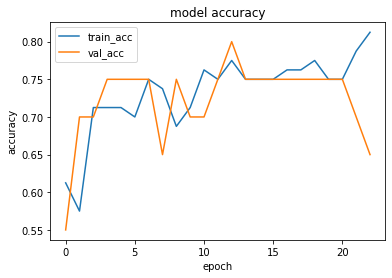

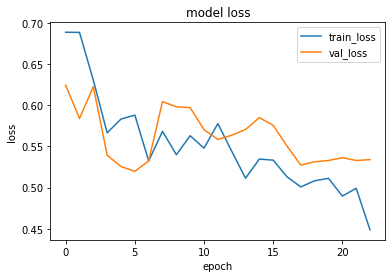

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.64953196]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.72183675]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.8325604]]


1it [00:00, 12336.19it/s]


prediction for video control_1.mov is [[0.3482799]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.27678138]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.24800813]]


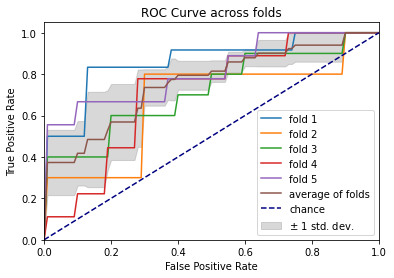

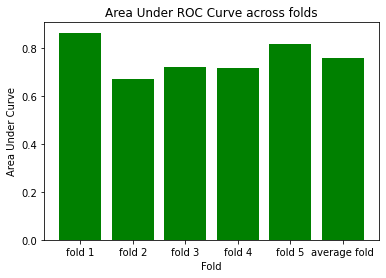

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 340ms/step - loss: 0.6948 - accuracy: 0.5000 - precision_87: 0.4643 - recall_87: 0.3421 - val_loss: 0.6909 - val_accuracy: 0.5500 - val_precision_87: 1.0000 - val_recall_87: 0.2500
Epoch 2/75
3/3 [==============================] - 1s 322ms/step - loss: 0.6708 - accuracy: 0.6250 - precision_87: 0.7000 - recall_87: 0.3684 - val_loss: 0.6317 - val_accuracy: 0.8000 - val_precision_87: 1.0000 - val_recall_87: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6484 - accuracy: 0.6625 - precision_87: 0.6774 - recall_87: 0.5526 - val_loss: 0.5779 - val_accuracy: 0.6500 - val_precision_87: 0.6471 - val_recall_87: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6451 - accuracy: 0.6875 - precision_87: 0.6383 - recall_87: 0.7895 - val_loss: 0.5844 - val_accuracy: 0.6500 - val_precision_87: 0.6471 - val_recall_87: 0.9167
Epoch 5/75
3/3 [==============================] - 1s 390ms/step 

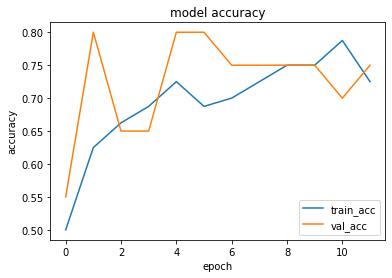

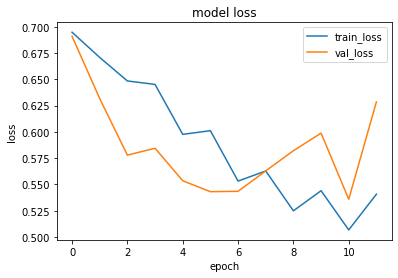

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.475626]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.49588537]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.49008775]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.46882087]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.46927258]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.46976712]]
Epoch 1/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6869 - accuracy: 0.5750 - precision_88: 0.5484 - recall_88: 0.8500 - val_loss: 0.7687 - val_accuracy: 0.5000 - val_precision_88: 0.0000e+00 - val_recall_88: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6973 - accuracy: 0.5500 - precision_88: 1.0000 - recall_88: 0.1000 - val_loss: 0.6540 - val_accuracy: 0.6500 - val_precision_88: 0.6667 - val_recall_88: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6187 - accuracy: 0.7250 - precision_88: 0.7045 - recall_88: 0.7750 - val_loss: 0.5988 - val_accuracy: 0.7500 - val_precision_88: 0.6923 - val_recall_88: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 381ms/step - loss: 0.6058 - accuracy: 0.6875 - precision_88: 0.6531 - recall_88: 0.8000 - val_loss: 0.6187 - val_accuracy: 0.7000 - val_precision_88: 0.7500 - val_recall_88: 0.6000
Epo

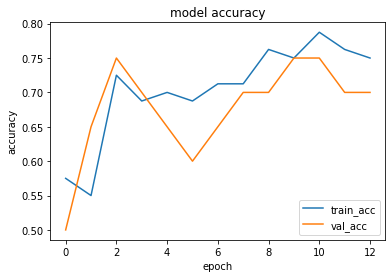

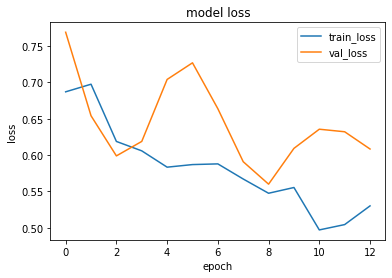

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.643518]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.60855454]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.77058756]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.45342672]]


1it [00:00, 11096.04it/s]


prediction for video control_2.mov is [[0.3317129]]


1it [00:00, 18641.35it/s]


prediction for video control_3.mov is [[0.3210585]]
Epoch 1/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6707 - accuracy: 0.6000 - precision_89: 0.5690 - recall_89: 0.8250 - val_loss: 0.6519 - val_accuracy: 0.7000 - val_precision_89: 0.7000 - val_recall_89: 0.7000
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6253 - accuracy: 0.6500 - precision_89: 0.6154 - recall_89: 0.8000 - val_loss: 0.6220 - val_accuracy: 0.7000 - val_precision_89: 0.7500 - val_recall_89: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 292ms/step - loss: 0.5767 - accuracy: 0.7500 - precision_89: 0.7273 - recall_89: 0.8000 - val_loss: 0.6183 - val_accuracy: 0.6500 - val_precision_89: 0.8000 - val_recall_89: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 290ms/step - loss: 0.5739 - accuracy: 0.7000 - precision_89: 0.7222 - recall_89: 0.6500 - val_loss: 0.5863 - val_accuracy: 0.6500 - val_precision_89: 0.8000 - val_recall_89: 0.4000
Epoch 5/75
3

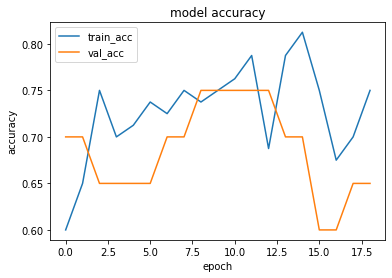

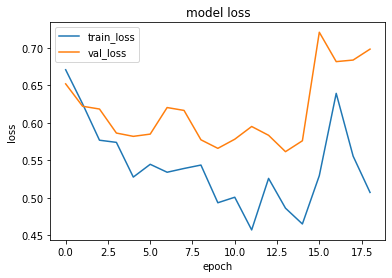

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.40729517]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.56869036]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.5320825]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.28834838]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.31976616]]


1it [00:00, 6413.31it/s]


prediction for video control_3.mov is [[0.30225748]]
Epoch 1/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6765 - accuracy: 0.4875 - precision_90: 0.5000 - recall_90: 0.8293 - val_loss: 0.6916 - val_accuracy: 0.6500 - val_precision_90: 0.6000 - val_recall_90: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6292 - accuracy: 0.7250 - precision_90: 0.7436 - recall_90: 0.7073 - val_loss: 0.6657 - val_accuracy: 0.6500 - val_precision_90: 0.5833 - val_recall_90: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.5808 - accuracy: 0.7125 - precision_90: 0.6875 - recall_90: 0.8049 - val_loss: 0.6553 - val_accuracy: 0.7000 - val_precision_90: 0.6667 - val_recall_90: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 298ms/step - loss: 0.5531 - accuracy: 0.7500 - precision_90: 0.8000 - recall_90: 0.6829 - val_loss: 0.6570 - val_accuracy: 0.5500 - val_precision_90: 0.5000 - val_recall_90: 0.2222
Epoch 5/75


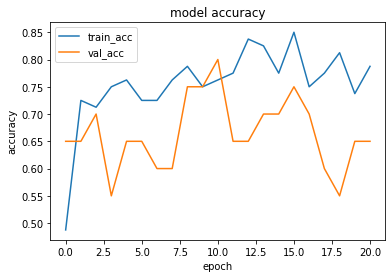

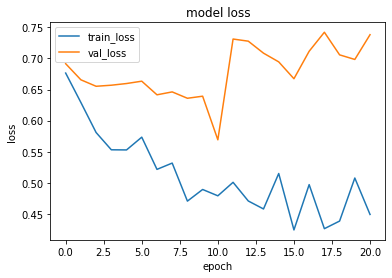

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.2669326]]


1it [00:00, 19152.07it/s]


prediction for video armflapping_3.mov is [[0.55315375]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.77244866]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.20988476]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.22606346]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.21831483]]
Epoch 1/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6973 - accuracy: 0.4625 - precision_91: 0.4844 - recall_91: 0.7561 - val_loss: 0.6322 - val_accuracy: 0.6000 - val_precision_91: 0.6667 - val_recall_91: 0.2222
Epoch 2/75
3/3 [==============================] - 1s 376ms/step - loss: 0.6917 - accuracy: 0.5250 - precision_91: 0.6000 - recall_91: 0.2195 - val_loss: 0.6210 - val_accuracy: 0.7000 - val_precision_91: 0.6364 - val_recall_91: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6422 - accuracy: 0.6875 - precision_91: 0.6739 - recall_91: 0.7561 - val_loss: 0.6182 - val_accuracy: 0.6500 - val_precision_91: 0.5833 - val_recall_91: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6003 - accuracy: 0.7375 - precision_91: 0.7000 - recall_91: 0.8537 - val_loss: 0.6093 - val_accuracy: 0.7000 - val_precision_91: 0.6667 - val_recall_91: 0.6667
Epoch 5/75


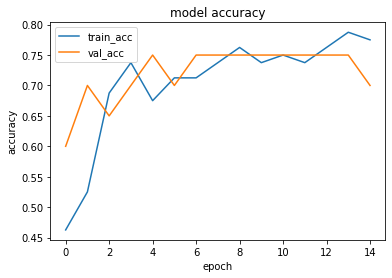

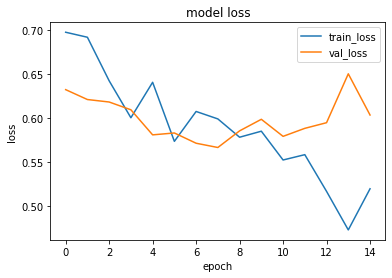

1it [00:00, 17924.38it/s]


prediction for video armflapping_1.mov is [[0.4494973]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.7755785]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.8003832]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.30012912]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.27404055]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.26943558]]


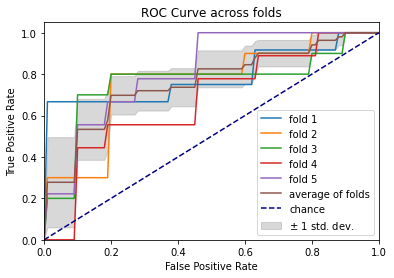

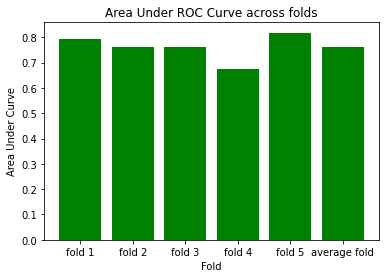

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 308ms/step - loss: 0.8337 - accuracy: 0.5125 - precision_93: 0.4909 - recall_93: 0.7105 - val_loss: 0.6549 - val_accuracy: 0.7500 - val_precision_93: 0.7692 - val_recall_93: 0.8333
Epoch 2/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6892 - accuracy: 0.6000 - precision_93: 0.5938 - recall_93: 0.5000 - val_loss: 0.6525 - val_accuracy: 0.6500 - val_precision_93: 0.7273 - val_recall_93: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6654 - accuracy: 0.6375 - precision_93: 0.6452 - recall_93: 0.5263 - val_loss: 0.6215 - val_accuracy: 0.7500 - val_precision_93: 0.7333 - val_recall_93: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6409 - accuracy: 0.7000 - precision_93: 0.6591 - recall_93: 0.7632 - val_loss: 0.5940 - val_accuracy: 0.7000 - val_precision_93: 0.6875 - val_recall_93: 0.9167
Epoch 5/75
3/3 [==============================] - 1s 296ms/step 

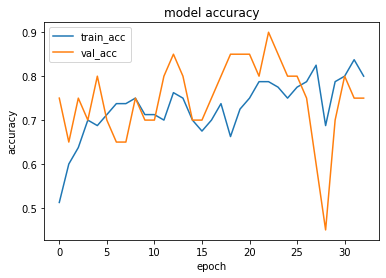

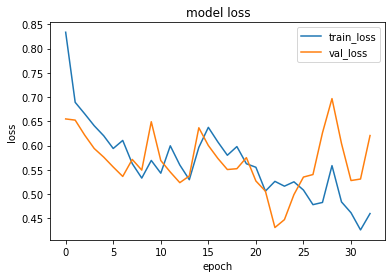

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.5061531]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.38138133]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.60047245]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.35920128]]


1it [00:00, 16980.99it/s]


prediction for video control_2.mov is [[0.2911498]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.27960703]]
Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6664 - accuracy: 0.6250 - precision_94: 0.6250 - recall_94: 0.6250 - val_loss: 0.6701 - val_accuracy: 0.5000 - val_precision_94: 0.5000 - val_recall_94: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 338ms/step - loss: 0.6782 - accuracy: 0.6375 - precision_94: 0.6038 - recall_94: 0.8000 - val_loss: 0.6423 - val_accuracy: 0.6500 - val_precision_94: 0.6667 - val_recall_94: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6380 - accuracy: 0.6625 - precision_94: 0.6970 - recall_94: 0.5750 - val_loss: 0.6234 - val_accuracy: 0.7500 - val_precision_94: 0.7273 - val_recall_94: 0.8000
Epoch 4/75
3/3 [==============================] - 1s 307ms/step - loss: 0.5916 - accuracy: 0.7000 - precision_94: 0.7105 - recall_94: 0.6750 - val_loss: 0.5319 - val_accuracy: 0.7000 - val_precision_94: 0.7500 - val_recall_94: 0.6000
Epoch 5/75


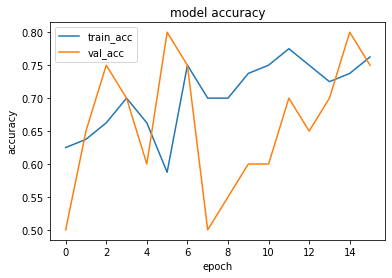

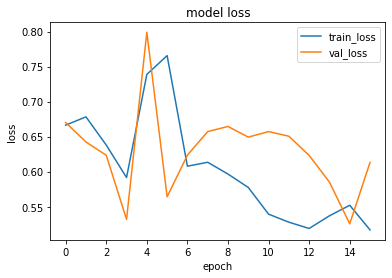

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.6642267]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.6773883]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.7375165]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.4514753]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.37080505]]


1it [00:00, 18641.35it/s]


prediction for video control_3.mov is [[0.3733747]]
Epoch 1/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6991 - accuracy: 0.5000 - precision_95: 0.5000 - recall_95: 0.4750 - val_loss: 0.6617 - val_accuracy: 0.5000 - val_precision_95: 0.5000 - val_recall_95: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6315 - accuracy: 0.6625 - precision_95: 0.6032 - recall_95: 0.9500 - val_loss: 0.6335 - val_accuracy: 0.7000 - val_precision_95: 0.7500 - val_recall_95: 0.6000
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.5928 - accuracy: 0.7625 - precision_95: 0.8182 - recall_95: 0.6750 - val_loss: 0.6585 - val_accuracy: 0.7000 - val_precision_95: 1.0000 - val_recall_95: 0.4000
Epoch 4/75
3/3 [==============================] - 1s 374ms/step - loss: 0.5690 - accuracy: 0.6875 - precision_95: 0.7419 - recall_95: 0.5750 - val_loss: 0.6309 - val_accuracy: 0.6500 - val_precision_95: 0.8000 - val_recall_95: 0.4000
Epoch 5/75
3

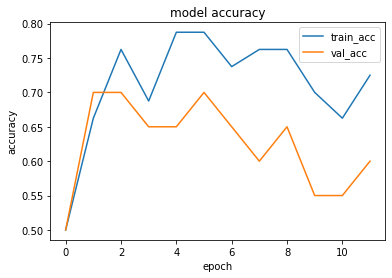

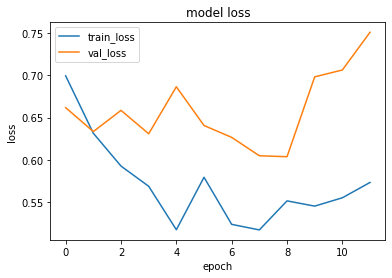

1it [00:00, 18893.26it/s]


prediction for video armflapping_1.mov is [[0.09961903]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.62948716]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_2.mov is [[0.13156798]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.4839837]]


1it [00:00, 14315.03it/s]


prediction for video control_2.mov is [[0.48474374]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.08585766]]
Epoch 1/75
3/3 [==============================] - 1s 310ms/step - loss: 0.7460 - accuracy: 0.5250 - precision_96: 0.5294 - recall_96: 0.6585 - val_loss: 0.6739 - val_accuracy: 0.6000 - val_precision_96: 0.5556 - val_recall_96: 0.5556
Epoch 2/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6624 - accuracy: 0.6625 - precision_96: 0.7333 - recall_96: 0.5366 - val_loss: 0.6636 - val_accuracy: 0.6000 - val_precision_96: 0.6000 - val_recall_96: 0.3333
Epoch 3/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6481 - accuracy: 0.6000 - precision_96: 0.6216 - recall_96: 0.5610 - val_loss: 0.6796 - val_accuracy: 0.6000 - val_precision_96: 0.5385 - val_recall_96: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.5996 - accuracy: 0.7250 - precision_96: 0.6863 - recall_96: 0.8537 - val_loss: 0.6837 - val_accuracy: 0.6500 - val_precision_96: 0.6000 - val_recall_96: 0.6667
Epoch 5/75


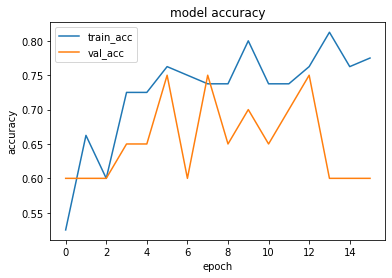

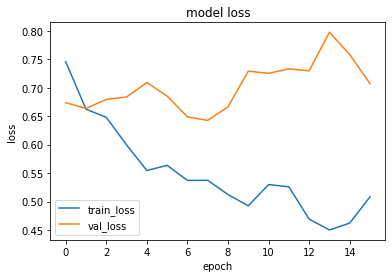

1it [00:00, 16644.06it/s]


prediction for video armflapping_1.mov is [[0.36458617]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.40442157]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.47835392]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.35924372]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.36051673]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.3604594]]
Epoch 1/75
3/3 [==============================] - 1s 378ms/step - loss: 0.6911 - accuracy: 0.5500 - precision_97: 0.5397 - recall_97: 0.8293 - val_loss: 0.6098 - val_accuracy: 0.7500 - val_precision_97: 0.7500 - val_recall_97: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6522 - accuracy: 0.6125 - precision_97: 0.7083 - recall_97: 0.4146 - val_loss: 0.6036 - val_accuracy: 0.7000 - val_precision_97: 0.6364 - val_recall_97: 0.7778
Epoch 3/75
3/3 [==============================] - 1s 302ms/step - loss: 0.6225 - accuracy: 0.6875 - precision_97: 0.6818 - recall_97: 0.7317 - val_loss: 0.6151 - val_accuracy: 0.6500 - val_precision_97: 0.5833 - val_recall_97: 0.7778
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6110 - accuracy: 0.7000 - precision_97: 0.6604 - recall_97: 0.8537 - val_loss: 0.5521 - val_accuracy: 0.7000 - val_precision_97: 0.6364 - val_recall_97: 0.7778
Epoch 5/75
3

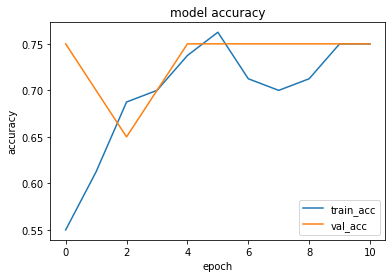

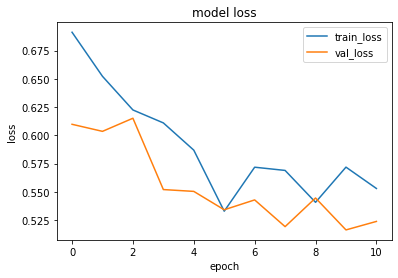

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.54945403]]


1it [00:00, 18808.54it/s]


prediction for video armflapping_3.mov is [[0.7107593]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.72991663]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.22143519]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.20255437]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.18967071]]


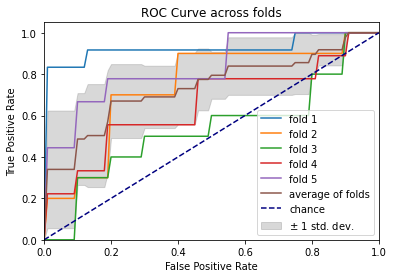

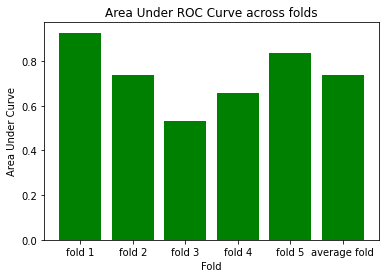

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

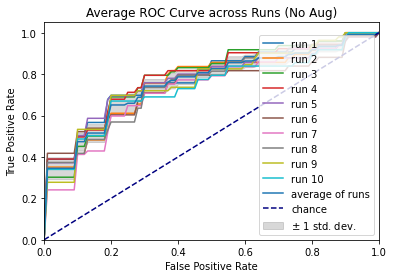

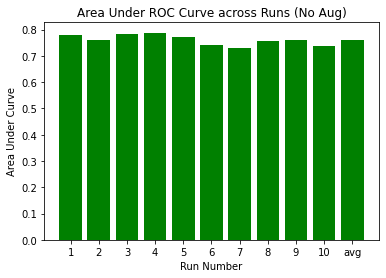

In [34]:
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101))

In [36]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.7615714646464646, 0.017821844191810696)